# Run the whole deltas algorithm

In [169]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pipeline
import deltas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get data and classifier

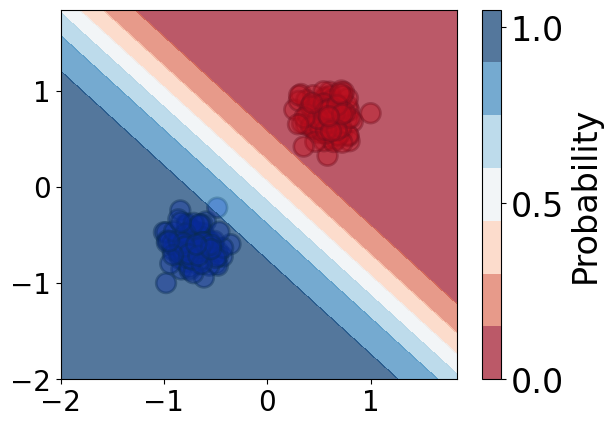

In [170]:
N1 = 100
N2 = 100
data_clf = pipeline.get_data_and_classifier(N1=N1, N2=N2)

data = data_clf['data']
clf = data_clf['clf']
m1 = data_clf['mean1']
m2 = data_clf['mean2']

## Get projection and data we need (R, D, M etc.)

1.8622720767645795
0.8418576867958157
R1 empirical: 0.46216610596193186
R2 empirical: 0.3796915808338839


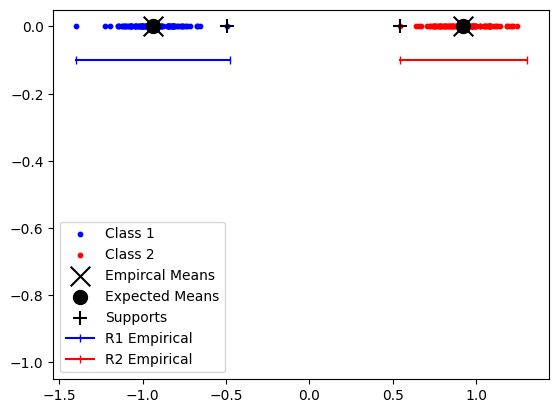

In [171]:
data_info = pipeline.data_project_and_info(
    data=data_clf['data'], m1=data_clf['mean1'], m2=data_clf['mean2'], clf=data_clf['clf'], data_test=data_clf['data_test'])

## set up extra parameters

In [172]:
# Costs
data_info['c1'] = 1
data_info['c2'] = 1
data_info['N1'] = N1
data_info['N2'] = N2
pipeline.print_params(data_info)

Parameters
        R:  1.3998424836251298
        N1: 100
        N2: 100
        R1: 0.46216610596193186
        R2: 0.3796915808338839
        M:  1.0388770118511124
        D:  1.8622720767645795
        C1: 1
        C2: 1


## Optimiser

-----------
optimising init deltas wrt. contraint
[       inf 3.16333092 3.11723144 ... 1.9673316  1.96569132 1.96173167] D: 1.8622720767645795
min: 0.09945959693133988
2.6023936805000103 D: 1.8622720767645795
2.602433274024741 D: 1.8622720767645795
2.6023936637244534 D: 1.8622720767645795
1.9617316736959194 D: 1.8622720767645795
1.9617712672206502 D: 1.8622720767645795
1.9617712672206502 D: 1.8622720767645795
deltas init found: 1.0, 1.0
1.9617316736959194 D: 1.8622720767645795
contraint 0.09945959693133988
-----------


/home/matt/projects/linear_confidence/radius.py:11: RuntimeWarning: divide by zero encountered in divide
  error = (R_sup/np.sqrt(N)) * (2 + (np.sqrt( 2*np.log(1/delta) )))


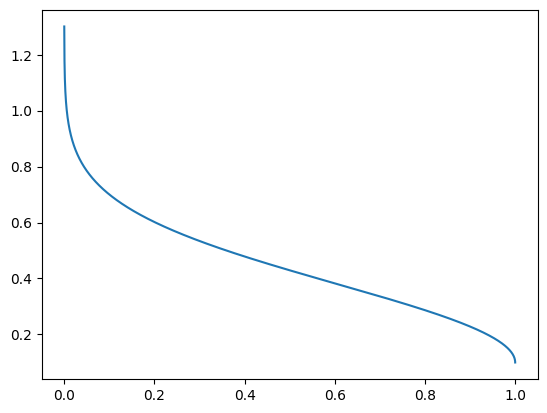

1.9617316736959194 D: 1.8622720767645795
constraint init: 0.09945959693133988 should equal 0
1.9617316736959194 D: 1.8622720767645795
1.9617316736959194 D: 1.8622720767645795
1.9617316736959194 D: 1.8622720767645795
1.9617800056351995 D: 1.8622720767645795
1.9617800056351995 D: 1.8622720767645795
delta1 : 1.0 
delta2: 1.0
1.9617316736959194 D: 1.8622720767645795
constraint: 0.09945959693133988 should equal 0
R1_est : 1.0221030994119837 
R2_est: 0.9396285742839358 
D_emp: 1.8622720767645795
1.8622720767645795
1.9617316736959194


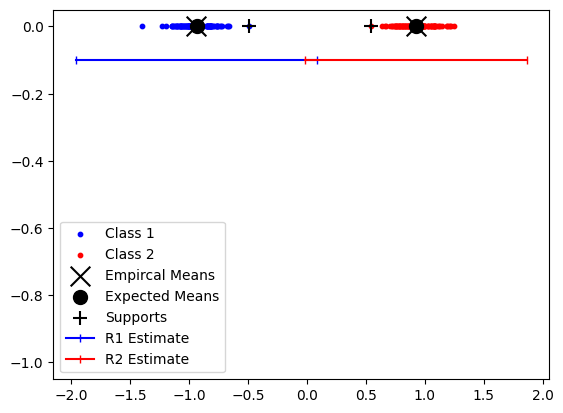

In [173]:

loss_func = deltas.scipy_optim_func   # returns tuple for (loss_func, gradient)
loss_func = deltas.loss_one_delta   # loss_func only - won't use gradient during optimisation
loss_func = lambda delta, data_info: deltas.loss(delta[0], delta[1], data_info)

contraint_func = deltas.contraint_eq7
# contraint_func = deltas.contraint_eq8
 
delta1, delta2 = pipeline.optimise(
    data_info, loss_func, contraint_func, num_deltas=2)

# Evaluation on test data

In [174]:
pipeline.eval_test(data_clf, data_info, delta1, delta2)

original accuracy: 1.0
deltas   accuracy: 1.0


In [175]:
N1 = data_info['N1']
N2 = data_info['N2']
R1_emp = data_info['empirical R1']
R2_emp = data_info['empirical R2']
R = data_info['R all data']
D_emp = data_info['empirical D']

def error(R, N, d):
    return 2*(R/np.sqrt(N)) * (2 + np.sqrt(2*np.log(1/d)))

delta1 = 1
delta2 = 0.74
R1_est = R1_emp + error(R, N1, delta1)
R2_est = R2_emp + error(R, N2, delta2)

print(R1_est)
print(R2_est)
print('--- D ---')
print(D_emp)
print(R1_emp+R2_emp+error(R, N2, 1) + error(R, N1, 1))
print('--- R ---')
print(R1_emp+R2_emp)
print(error(R, N1, delta1) +
      error(R, N2, delta2))
print('--- C ---')
print(R1_emp+R2_emp + error(R, N1, delta1) +
      error(R, N2, delta2))
print('--- d ---')
B = D_emp - R2_emp - R1_emp - error(R, N1, delta1)
# 2*(R/np.sqrt(N)) * (2 + np.sqrt(2*np.log(1/d))) = B
# (2 + np.sqrt(2*np.log(1/d))) = (B/2*(R/np.sqrt(N)))
# np.sqrt(2*np.log(1/d)) = (B/2*(R/np.sqrt(N))) - 2
# 2*np.log(1/d) = np.square((B/2*(R/np.sqrt(N))) - 2)
# np.log(1/d) = (np.square((B/2*(R/np.sqrt(N))) - 2) / 2)
# 1/d = np.exp((np.square((B/2*(R/np.sqrt(N))) - 2) / 2))
delta2 = 1/np.exp(0.5*(np.square(((B*np.sqrt(N2))/(2*R)) - 2)))
delta2 = deltas.delta2_given_delta1_matt(delta1, data_info)
# delta2 = np.exp(-np.square( (np.sqrt(N2)*B)/(2*np.sqrt(2)*R) -np.sqrt(2)))
# delta2 = np.exp(-0.5*np.square((np.sqrt(N2)*B)/(2*R) - 2))
# delta2 = deltas.delta2_given_delta1(delta1, data_info)
print(delta2)
print(error(R, N2, 1))
print(f'B: {B}')
print(2*(R/np.sqrt(N2)) * (2 + np.sqrt(2*np.log(1/delta2))))

1.0221030994119837
1.156890294460473
--- D ---
1.8622720767645795
1.9617316736959194
--- R ---
0.8418576867958157
1.3371357070766412
--- C ---
2.178993393872457
--- d ---
0.9388474418304116
0.5599369934500519
B: 0.4604773965187118
0.659396590381392
